### Github
https://github.com/nielsenchristianole/02467-Computational-Social-Science/blob/main/Part%202.ipynb

### Contribution
Everyone has worked equally on each exercise which have contributed to this assignment and the assignment itself. Even tho one may have uploaded more to the github, the uploads where done in unison.

# Missing
2.1: 3. 4.
2.2: 5. 6.
3:   2.5
4:   *

In [14]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from scipy.stats import pearsonr
import networkx as nx
import simplejson as json
import netwulf

# Part 2

In [2]:
GME_market_data = pd.read_csv('GME.csv',parse_dates=['Date'],).set_index('Date')

In [3]:
df_comments_raw = pd.read_csv('./data_comments.csv')
df_comments_raw['time'] = [datetime.utcfromtimestamp(time + np.random.rand()) for time in df_comments_raw['created_utc']]
df_comments = df_comments_raw[df_comments_raw['created_utc'] <= 1611529173].copy().set_index('time')
df_comments['num_comments'] = np.ones(len(df_comments))
df_comments = df_comments.sort_index()

df_finance = pd.read_csv('GME.csv', parse_dates=['Date']).set_index('Date')
df_finance['num_comments'] = df_comments['num_comments'].resample('1D').sum()[df_finance.index]

In [4]:
import matplotlib as mpl
import matplotlib.dates as mdates

def setup_mpl():
    mpl.rcParams['font.family'] = 'Comic Sans MS'
    mpl.rcParams['lines.linewidth'] = 1
setup_mpl()

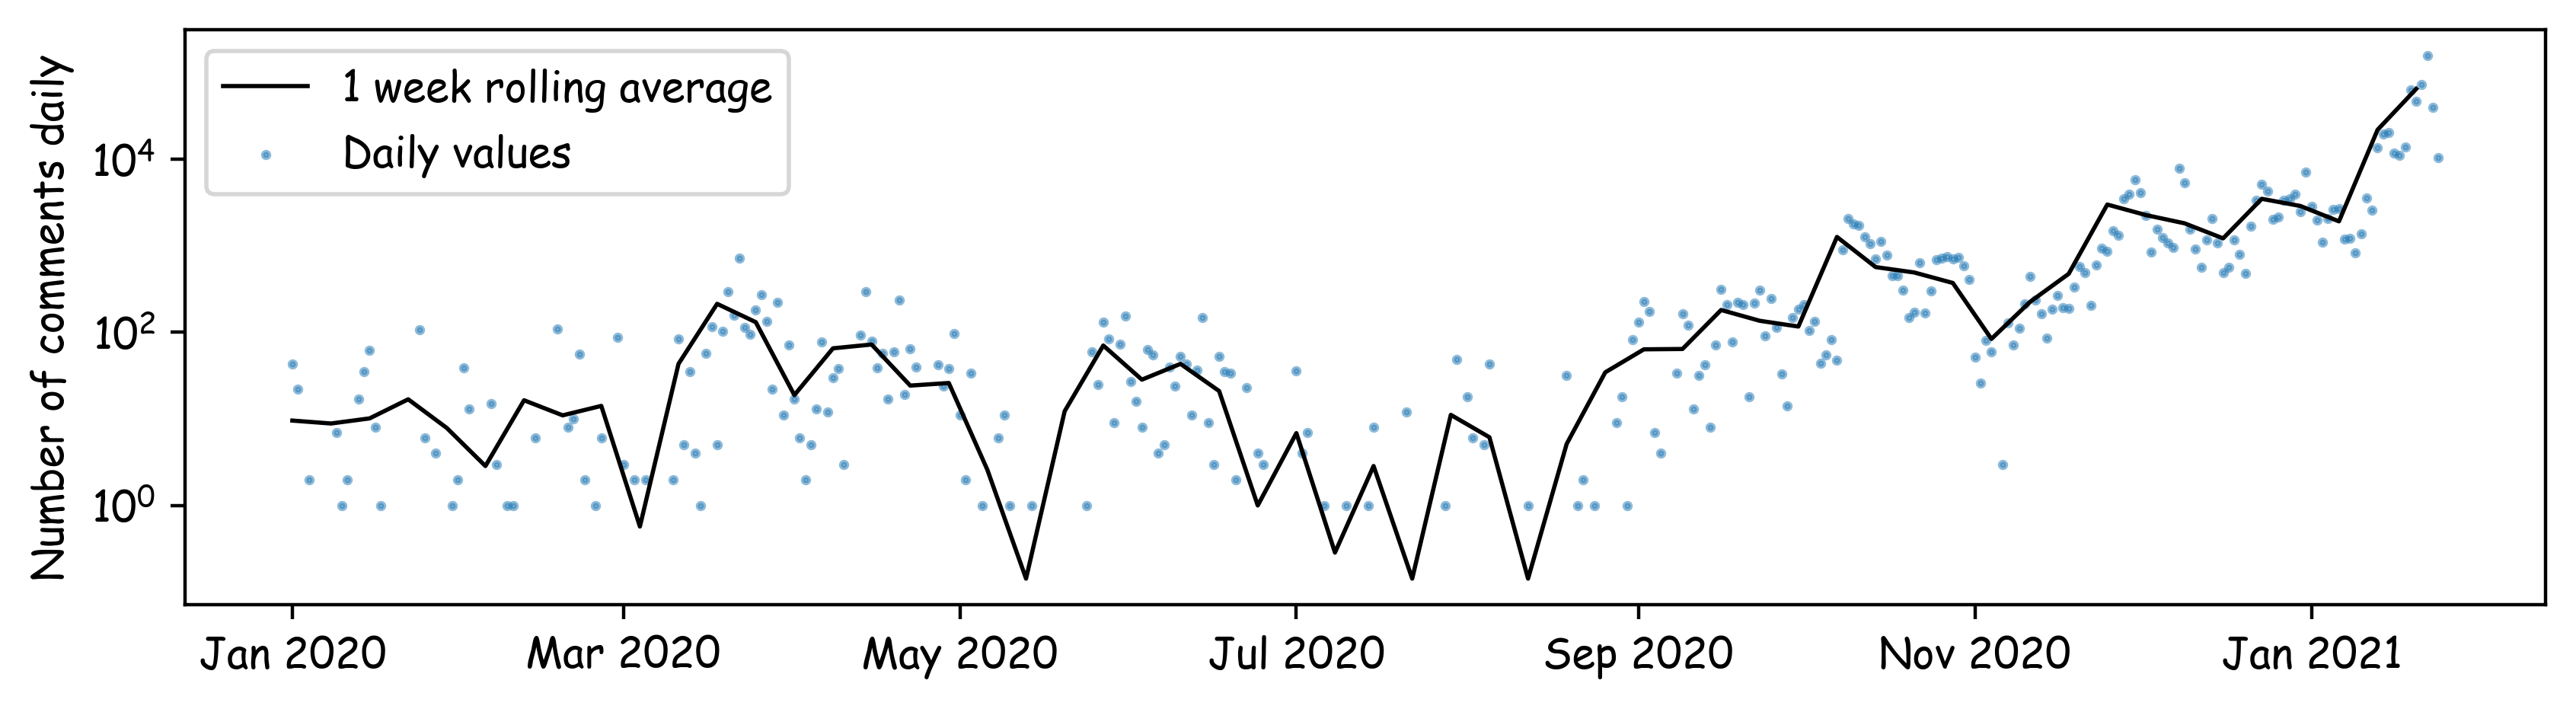

In [5]:
myFmt = mdates.DateFormatter('%b %Y')
fig, ax  = plt.subplots(figsize=[10, 2.5], dpi=400)


rolled_series = df_comments['num_comments'].resample('1D').sum()
ax.scatter(rolled_series.index, rolled_series.values, alpha=0.5, s=2, label="Daily values")

rolled_series = rolled_series.resample('7D').mean()
ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")

ax.set_ylabel('Number of comments daily')
ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.show()

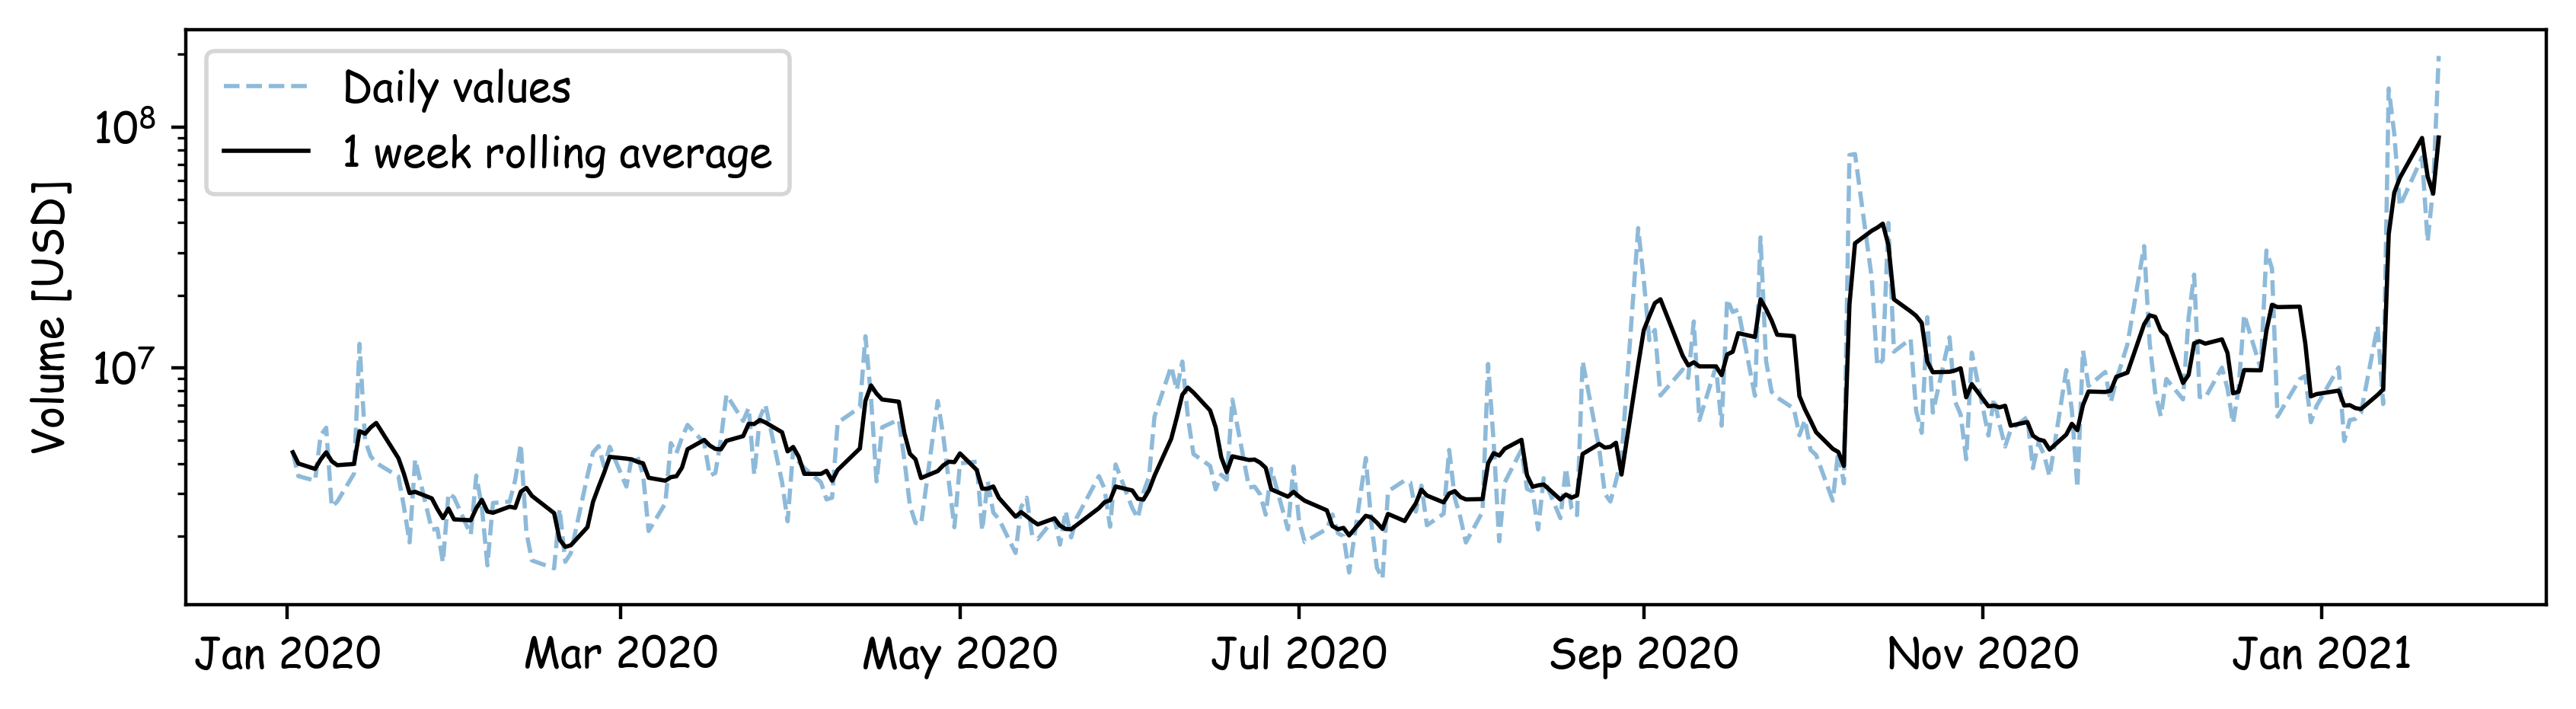

In [6]:
myFmt = mdates.DateFormatter('%b %Y')
fig, ax  = plt.subplots(figsize=[10, 2.5], dpi=400)
ax.plot(df_finance.index, df_finance['Volume'], ls='--', alpha=0.5, label="Daily values")

rolled_series = df_finance['Volume'].rolling('7D').mean()
ax.plot(rolled_series.index, rolled_series.values, color='k', label="1 week rolling average")

ax.set_ylabel('Volume [USD]')
ax.set_yscale('log')
ax.legend()
ax.xaxis.set_major_formatter(myFmt)
plt.show()

def plot_21(dataframe: pd.DataFrame, column, xlabel, ylabel, title):
    running_mean = dataframe.rolling(f'{60*60*24*7}s').mean()[column]
    plt.plot(running_mean.index, np.log(running_mean))
    plt.plot(dataframe.index, np.log(dataframe[column]),'--',linewidth = 0.6)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.show()

plot_21(GME_market_data, 'Volume','date','log(Volume)','Volume of GME')
plot_21(comments_dataset_num, 'num_comments','date','log(Volume)','Volume of GME')

What is the advantage of using the log-scale on the y-axis? What is the advantage of using a rolling-window?
Now take a minute to look at these two figures. Then write in a couple of lines: What are the three most important observations you can draw by looking at the figures?

In [7]:
log_return_volume = np.log(df_finance['Volume'] / df_finance['Volume'].shift())
log_return_comments = np.log(df_finance['num_comments'] / df_finance['num_comments'].shift())

df = pd.DataFrame({'Volume': log_return_volume,
                   'num_comments': log_return_comments})

df.replace([-np.inf, np.inf], np.nan, inplace=True)
df.dropna(inplace=True)

C:\Users\niels\anaconda3\lib\site-packages\pandas\core\series.py:726: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


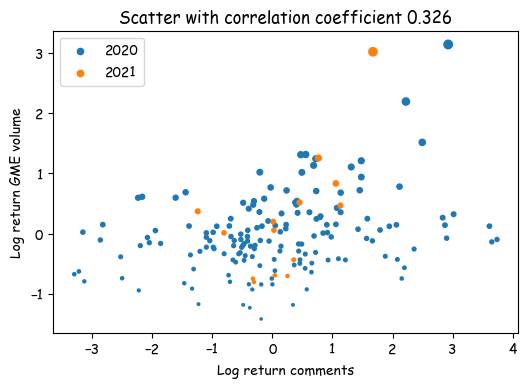

In [8]:
day_critical = datetime(year=2021, month=1, day=1)

fig, ax = plt.subplots(dpi=100)

ax.scatter(df['num_comments'][df.index < day_critical],
           df['Volume'][df.index < day_critical],
           s=(df['Volume'][df.index < day_critical] + 3)**2,
           label="2020")

ax.scatter(df['num_comments'][df.index >= day_critical],
           df['Volume'][df.index >= day_critical],
           s=(df['Volume'][df.index >= day_critical] + 3)**2,
           label="2021")

ax.set_xlabel('Log return comments')
ax.set_ylabel('Log return GME volume')

p_nr, _ = pearsonr(df['num_comments'], df['Volume'])
plt.title(f'Scatter with correlation coefficient {p_nr:.3}')

ax.legend()
plt.show()

# Part 3

**Königsberg Problem**
Each corner can be represented as as node and each line an edge. The problem is now analogous finding Euler paths in the graphs. This can be done if and only if two or less nodes has an uneven degree assuming all nodes belongs in the same graph.

The above is true for a., c. and d. where b has four nodes of degree 3.

**Graph Representation**



In [9]:
A = np.array([[0, 1, 1, 1, 0, 1],
              [1, 0, 1, 1, 0, 0],
              [1, 1, 0, 0, 0, 1],
              [1, 1, 0, 0, 0, 0],
              [0, 0, 0, 0, 0, 0],
              [1, 0, 1, 0, 0, 0]])

dA = np.array([[0, 1, 0, 0, 0, 0],
               [0, 0, 1, 1, 0, 0],
               [1, 1, 0, 0, 0, 0],
               [1, 0, 0, 0, 0, 0],
               [0, 0, 0, 0, 0, 0],
               [1, 0, 1, 0, 0, 0]])


def link_list(A):
    A = np.pad(A, 1)
    d = {i: list(np.where(row)[0]) for i, row in enumerate(A) if max(row)}
    return d

G = nx.convert_matrix.from_numpy_matrix(A)
dG = nx.convert_matrix.from_numpy_matrix(dA, create_using=nx.DiGraph)

def all_paths(G, start_nodes, target_node, iteration):
    
    iteration -= 1
    
    if iteration <= 0:
        count = 0
        for e in start_nodes:
            if e == target_node:
                count += 1
        return count
    else:
        end_nodes = []
        for node in start_nodes:
            end_nodes.extend(list(G.adj[node]))
        
        return all_paths(G, end_nodes, target_node, iteration)


Undirected:

In [10]:
print("Adjecency list:\n", A)
print("\nLink list:\n", link_list(A))

Adjecency list:
 [[0 1 1 1 0 1]
 [1 0 1 1 0 0]
 [1 1 0 0 0 1]
 [1 1 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 0 0]]

Link list:
 {1: [2, 3, 4, 6], 2: [1, 3, 4], 3: [1, 2, 6], 4: [1, 2], 6: [1, 3]}


Directed:

In [11]:
print("Adjecency list:\n", dA)
print("\nlink list:\n", link_list(dA))

Adjecency list:
 [[0 1 0 0 0 0]
 [0 0 1 1 0 0]
 [1 1 0 0 0 0]
 [1 0 0 0 0 0]
 [0 0 0 0 0 0]
 [1 0 1 0 0 0]]

link list:
 {1: [2], 2: [3, 4], 3: [1, 2], 4: [1], 6: [1, 3]}


In [12]:
print(f"\nAverage clustering coefficient of 2.20a: {nx.average_clustering(G):.2}")


Average clustering coefficient of 2.20a: 0.64


Switching the labels of two nodes corrosponds to swapping the
two nodes columns and rows in the adjecency matrix.
For the linked list it corrosponds to just switching the key labels

In a link list, you can't see the weight of the edge.
However it's quite easy to modify the implementation to support storing of edge weights.

In [13]:
print("In the (a) network, how many paths (with possible repetition of nodes and links)\
of length 3 exist starting from node 1 and ending at node 3?\n", all_paths(G, list(G.adj[0]), 2, 3))

print("\nAnd in (b)?\n", all_paths(dG, list(dG.adj[0]), 2, 3))

print("\nWith the help of a computer, count the number of cycles of length 4 in both networks.")
print("For (a):", sum([all_paths(G, list(G.adj[i]), i, 4) for i in range(6)]), "\nFor (b): ", sum([all_paths(dG, list(dG.adj[i]), i, 4) for i in range(6)]))

In the (a) network, how many paths (with possible repetition of nodes and links)of length 3 exist starting from node 1 and ending at node 3?
 7

And in (b)?
 0

With the help of a computer, count the number of cycles of length 4 in both networks.
For (a): 86 
For (b):  2


# Part 4:

For this part of the assignment, consider the directed network of redditors posting about GME on r/wallstreetbets in the period included between Jan 1st and Dec 31st, 2020 (the one you built in Week 3, Part 3).

> _Part 4.1 Random Network_: Create a Random Network as a null model to investigate some properties of the Redditors Network.
> * Compute the value of _p_ such that the number of expected edges of the random network equals the number of edges in the redditor network (see equation 3.2 in your Network Science Book). What is the value of p? Compute the average value of the degree < k > (using the formula).
> * Create a Random network with the same number of nodes as the redditor networks, and _p_ as computed above. Generate a random network by linking nodes in every possible pair with probability _p_.
> * Visualize the Redditors Network and the Random Network. Comment on the differences between the two.

In [18]:
# import redditors network graph file, and convert to undirected reciprocal.
filename = './reddit_network.json'

with open(filename) as f:
    data = json.load(f)
    directed_reddit_network = nx.node_link_graph(data, directed=True)
    reddit_network = directed_reddit_network.to_undirected(reciprocal=True)
    
reddit_network.remove_edges_from(nx.selfloop_edges(reddit_network))
reddit_network.remove_nodes_from(list(nx.isolates(reddit_network)))

# print how many nodes was removed, when removing isolates
proportion_of_nodes_kept = reddit_network.number_of_nodes()/directed_reddit_network.number_of_nodes()
print(f'Kept {reddit_network.number_of_nodes()} \
nodes of {directed_reddit_network.number_of_nodes()}, \
{proportion_of_nodes_kept:.2%}, \
post clean')
print(f'This means, that {proportion_of_nodes_kept:.2%} of the redditors have no others they interact with on reddit.')


Kept 10308 nodes of 26255, 39.26%, post clean
This means, that 39.26% of the redditors have no others they interact with on reddit.


In [19]:
#compute p using equation 3.2 fom NS
L = reddit_network.number_of_edges()
N = reddit_network.number_of_nodes()
p = L*2/(N*(N-1))
print(f'p = {p:.5%}')

p = 0.03026%


In [21]:
#create random network

# loop over all pairs of nodes
# for each pair, generate random number, r, from uniform (0,1) dist
# if r <= p, add edge to edge list
# finally create graph from edge list
edge_list = []
for node1 in range(N-1):
    print(f'\r{node1/N:.0%}',end = '')
    for node2 in range(node1+1,N):
        if np.random.rand() <= p: edge_list.append((node1,node2))

random_network = nx.Graph()
random_network.add_edges_from(edge_list)

100%

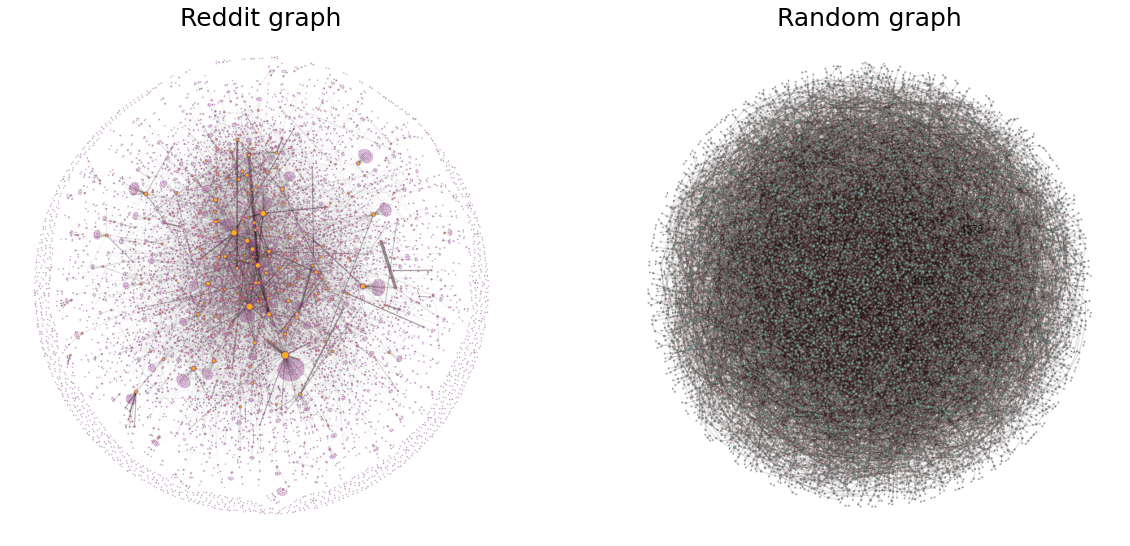


It is hard to really compare the two visualisations, as the results depend
heavily on how we tweak the visualization parameters.
The best way to asses the differences between the two graphs, is the fact
that we weren't able to find a good way of visualising the random graph.

It is clear to see, on the reddit graph, that the redditors seem to
behave as a real world social network.
Some redditors are popular, as many people interact with them, while 
some redditors only interact with a few others. Additionally, some of the 
edges are very heavy, which means that some redditors interact a lot
with each other, while some don't interact that much.



In [36]:
#Visualizing the networks
# visualized using netwulf.visualize(graph)
# - tweaked in the interactive editor, and stored as image
# here the results are shown


img_reddit = mpimg.imread('reddit_network.png')
img_random = mpimg.imread('random_network.png')
fig, axs = plt.subplots(1, 2 ,figsize = (20,15))
axs[0].axis('off')
axs[1].axis('off')
axs[0].set_title('Reddit graph', fontsize = 25)
axs[1].set_title('Random graph', fontsize = 25)
axs[0].imshow(img_reddit)
axs[1].imshow(img_random)
plt.show()

print("""
It is hard to really compare the two visualisations, as the results depend
heavily on how we tweak the visualization parameters.
The best way to asses the differences between the two graphs, is the fact
that we weren't able to find a good way of visualising the random graph.

It is clear to see, on the reddit graph, that the redditors seem to
behave as a real world social network.
Some redditors are popular, as many people interact with them, while 
some redditors only interact with a few others. Additionally, some of the 
edges are very heavy, which means that some redditors interact a lot
with each other, while some don't interact that much.
""")

> _Part 4.2 Clustering_: Compare the clustering coefficient in the Redditors Network and its random counterpart.
> * Compute the clustering coefficient for all nodes in the random network, using the formula 2.15 in your book.  
> * Compute the average clustering across nodes of the random network. Is it consistent with the analytical prediction (network science book equation 3.21)?
> * Compute the average clustering coefficient for the Redditors network. How does it compare to its random counterpart? Is it something you would expect? Why?

In [37]:
#compute clustering coefficients
 
#first create function
def compute_clustering_coefficients(graph):
    clc = {}
    for node in graph.nodes:
        n_triangles = 0
        neighbours = list(graph[node].keys())
        n_neighbours = len(neighbours)
        if n_neighbours != 1:
            for i in range(n_neighbours-1):
                for j in range(i+1,n_neighbours):
                    n_triangles += neighbours[i] in graph[neighbours[j]]
            clust_coef = 2*n_triangles/(n_neighbours*(n_neighbours-1))
        else:
            clust_coef = 0
        clc[node] = clust_coef
    return clc

#compute using the function
reddit_clustering_coefficients = compute_clustering_coefficients(reddit_network)
random_clustering_coefficients = compute_clustering_coefficients(random_network)

In [38]:
print(np.mean(list(reddit_clustering_coefficients.values())))
print(np.mean(list(random_clustering_coefficients.values())))

0.018421707834617482
0.00026983483178981047
